In [1]:
import os
import random
from typing import List
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import sklearn.model_selection as model_selection
import matplotlib.pyplot as plt

In [2]:
random.seed(42)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Store all file names in list.

In [5]:
names = [filename.split('.')[0] for filename in os.listdir('food') if filename.endswith('jpg')]
names.sort()

Load ResNet50 model.

In [6]:
model = models.resnet50(pretrained=True).to(device)
layer = model._modules.get('avgpool')
model.eval()

/Users/jonas/Projects/school/iml/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jonas/Projects/school/iml/venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/jonas/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:19<00:00, 5.16MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Preprocessing & Extracting Features

Images are transformed into a form expected by ResNet50 and then we obtain the internal representation (corresponding to the second-to-last layer).

In [7]:
IMAGE_SIZE = 224
FEATURE_SIZE = 2048

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
def extract_features(file: str) -> torch.Tensor:
  input_image = Image.open(file)
  input_tensor = transform(input_image)
  input_batch = input_tensor.unsqueeze(0).to(device)

  features = torch.zeros(FEATURE_SIZE)
  def store_features(m, i, o):
    features.copy_(o.data.reshape(-1))
  h = layer.register_forward_hook(store_features)

  with torch.no_grad():
    model(input_batch)

  h.remove()
  return features

In [9]:
features = [extract_features(f'food/{name}.jpg') for name in tqdm(names)]

100%|██████████| 10000/10000 [06:21<00:00, 26.21it/s]


In [11]:
features_t = torch.stack(features)
torch.save(features_t, 'data/features.pt')

In [12]:
features_t = torch.load('data/features.pt')

# First Approach (this wasn't good enough)

A naïve approach (not using the training data) is to compare image representations using cosine similarity. This yields an accuracy of ~64%.

In [13]:
cos = torch.nn.CosineSimilarity(dim=0)

def predict_cos_(a: str, b: str, c: str) -> int:
  a_features = features_t[names.index(a)].reshape(-1)
  b_features = features_t[names.index(b)].reshape(-1)
  c_features = features_t[names.index(c)].reshape(-1)
  return int(cos(a_features, c_features) <= cos(a_features, b_features))

def predict_cos(lines: List[str]) -> torch.Tensor:
  y_pred = []
  for line in lines:
    [a, b, c] = line.split(' ')
    y_pred.append(predict_cos_(a, b, c))
  return torch.tensor(y_pred)

## Evaluation

In [14]:
correct = 0
wrong = 0
unsure = 0
total = 0

with open('train_triplets.txt') as f:
  for l in tqdm(f.read().splitlines()):
    [a, b, c] = l.split(' ')
    prediction = predict_cos_(a, b, c)
    if prediction == 1:
      correct += 1
    elif prediction == 0:
      wrong += 1
    else:
      correct += 0.5
      wrong += 0.5
      unsure += 1
    total += 1

correct / total, wrong / total, unsure / total

100%|██████████| 59515/59515 [00:05<00:00, 10786.19it/s]


(0.6397042762328825, 0.36029572376711755, 0.0)

# Second Approach

We train a fully connected NN on the binary classification task.

### Architecture

In [15]:
INPUT_SIZE = 3 * FEATURE_SIZE

class FCN(nn.Module):
  def __init__(self):
    super().__init__()
    self.do = nn.Dropout(p=0.8)
    self.fc1 = nn.Linear(INPUT_SIZE, 1024)
    self.fc2 = nn.Linear(1024, 256)
    self.fc3 = nn.Linear(256, 64)
    self.fc4 = nn.Linear(64, 16)
    self.fc5 = nn.Linear(16, 1)

  def forward(self, x):
    x = torch.relu(self.do(x))
    x = torch.relu(self.fc1(x))
    x = torch.relu(self.fc2(x))
    x = torch.relu(self.fc3(x))
    x = torch.relu(self.fc4(x))
    x = torch.sigmoid(self.fc5(x))
    return x

net = FCN().to(device)

In [35]:
criterion = nn.BCELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters())

### Prepare Training Data

In [36]:
def prepare_features(a: str, b: str, c: str) -> torch.Tensor:
  a_features = features_t[names.index(a)].reshape(-1)
  b_features = features_t[names.index(b)].reshape(-1)
  c_features = features_t[names.index(c)].reshape(-1)
  return torch.cat([a_features, b_features, c_features])

In [37]:
X = []
y = []

with open('train_triplets.txt') as f:
  for l in tqdm(f.read().splitlines()):
    [a, b, c] = l.split(' ')

    label = round(random.random())
    if label:
      X.append(prepare_features(a, b, c))
    else:
      X.append(prepare_features(a, c, b))
    y.append(label)

X_t = torch.stack(X)
y_t = torch.tensor(y)

del X
del y

100%|██████████| 59515/59515 [00:04<00:00, 12994.24it/s]


In [38]:
torch.save(X_t, 'data/X.pt')
torch.save(y_t, 'data/y.pt')

In [39]:
X_t = torch.load('data/X.pt')
y_t = torch.load('data/y.pt')

In [40]:
y_t = y_t.float()

In [41]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_t, y_t, test_size=0.2, random_state=42)

del X_t
del y_t

In [42]:
BATCH_SIZE = 32

train_set = TensorDataset(X_train, y_train)
test_set = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

### Training

In [43]:
EPOCHS = 25

net.train()

for epoch in range(EPOCHS):
  running_loss = 0.0
  for i, data in enumerate(train_loader):
    X, y = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()
    output = net(X).squeeze()
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
  print(f'[{epoch + 1}] average loss per epoch: {running_loss / len(train_loader):.3f}')

torch.save(net.state_dict(), 'data/net.pt')

[1] average loss per epoch: 0.625
[2] average loss per epoch: 0.610
[3] average loss per epoch: 0.601
[4] average loss per epoch: 0.596
[5] average loss per epoch: 0.592
[6] average loss per epoch: 0.588
[7] average loss per epoch: 0.586
[8] average loss per epoch: 0.582
[9] average loss per epoch: 0.580
[10] average loss per epoch: 0.580
[11] average loss per epoch: 0.574
[12] average loss per epoch: 0.574
[13] average loss per epoch: 0.572
[14] average loss per epoch: 0.572
[15] average loss per epoch: 0.568
[16] average loss per epoch: 0.567
[17] average loss per epoch: 0.564
[18] average loss per epoch: 0.564
[19] average loss per epoch: 0.560
[20] average loss per epoch: 0.556
[21] average loss per epoch: 0.556
[22] average loss per epoch: 0.556
[23] average loss per epoch: 0.555
[24] average loss per epoch: 0.554
[25] average loss per epoch: 0.551


In [44]:
net = FCN()
net.load_state_dict(torch.load('data/net.pt'))
net.to(device)
net.eval()

FCN(
  (do): Dropout(p=0.8, inplace=False)
  (fc1): Linear(in_features=6144, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
)

### Testing

In [45]:
correct = 0
total = 0

with torch.no_grad():
  for data in test_loader:
    X, y = data[0].to(device), data[1].to(device)

    output = net(X).squeeze()
    y_pred = torch.round(output)
    
    total += y.size(0)
    correct += (y_pred == y).sum().item()

print(f'Accuracy of the network on the {total} test queries: {100 * correct // total}%')

Accuracy of the network on the 11903 test queries: 72%


### Prediction

In [46]:
def predict_fcn(lines: List[str]) -> torch.Tensor:
  X = []
  for line in lines:
    [a, b, c] = line.split(' ')
    X.append(prepare_features(a, b, c))
  X_t = torch.stack(X).to(device)
  del X
  
  with torch.no_grad():
    output = net(X_t).squeeze()
  y_pred = torch.round(output)

  return y_pred.cpu()

# Wrapup

In [47]:
predict = predict_fcn

## Compute Submission

In [48]:
with open('test_triplets.txt') as f:
  y_pred = predict(f.read().splitlines())
  np.savetxt('submission.txt', y_pred.numpy(), fmt='%i')

## Testing

In [49]:
def view_example(inp: str):
  plt.figure(figsize=(25, 25))
  names = inp.split(' ')
  for index, name in enumerate(names):
    plt.subplot(10, 10, index + 1)
    img = Image.open(f'food/{name}.jpg')
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')
  print(f'Prediction: {predict([inp])}')

Prediction: 0.0


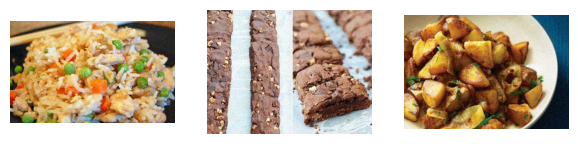

In [50]:
view_example('06592 09283 07104')